In [1]:
import torch
import numpy as np
from Packages.RegistrationFunc import *
from Packages.SplitEbinMetric import *
from Packages.GeoPlot import *
import scipy.io as sio
import matplotlib.pyplot as plt
import SimpleITK as sitk

g00 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Brains/103818_thresh_tensors.nhdr'))
g22 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Brains/111312_thresh_tensors.nhdr'))
mask0 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Brains/103818_filt_mask.nhdr'))
mask2 = sitk.GetArrayFromImage(sitk.ReadImage('Data/Brains/111312_filt_mask.nhdr'))
mask = mask0 + mask2
mask[mask>0] = 1

g00 = torch.from_numpy(g00).double()
g22 = torch.from_numpy(g22).double()
mask = torch.from_numpy(mask).double().permute(1,0)
mask0 = torch.from_numpy(mask0).double().permute(1,0)
mask2 = torch.from_numpy(mask2).double().permute(1,0)
g00 = g00.permute(1,0,2)
g22 = g22.permute(1,0,2)
print(g00.shape)

torch.Size([3, 145, 174])


In [2]:
height, width = g00.shape[1], g00.shape[2]
g0m = torch.zeros(height,width,2,2,dtype=torch.double)
g2m = torch.zeros(height,width,2,2,dtype=torch.double)
# gt = torch.zeros(height,width,2,2,dtype=torch.double)
g0m[:,:,0,0] = g00[0]
g0m[:,:,0,1] = g00[1]
g0m[:,:,1,0] = g00[1]
g0m[:,:,1,1] = g00[2]
g2m[:,:,0,0] = g22[0]
g2m[:,:,0,1] = g22[1]
g2m[:,:,1,0] = g22[1]
g2m[:,:,1,1] = g22[2]
print(g0m.shape,g2m.shape)
# g0m=torch.einsum('ij...,kij->ij...',torch.inverse(g0m),mask00.unsqueeze(0))+torch.einsum('ij...,kij->ij...',g0m,mask00inv.unsqueeze(0)*1e3)
# g2m=torch.einsum('ij...,kij->ij...',torch.inverse(g2m),mask22.unsqueeze(0))+torch.einsum('ij...,kij->ij...',g2m,mask22inv.unsqueeze(0)*1e3)
g0m=torch.inverse(g0m)
g2m=torch.inverse(g2m)

torch.Size([145, 174, 2, 2]) torch.Size([145, 174, 2, 2])


In [3]:
# define the pullback action of phi
def phi_pullback(phi, g):
    g = g.permute(2,3,0,1)
    idty = get_idty(*g.shape[-2:])
#     four layers of scalar field, of all 1, all 0, all 1, all 0, where the shape of each layer is g.shape[-2:]?
    d_phi = get_jacobian_matrix(phi - idty) + torch.einsum("ij,mn->ijmn", [torch.eye(2,dtype=torch.double),
                                                                           torch.ones(g.shape[-2:],dtype=torch.double)])
    g_phi = compose_function(g, phi)
#     matrix multiplication
# the last two dimension stays the same means point-wise multiplication, ijmn instead of jimn means the first d_phi need to be transposed
    return torch.einsum("ijmn,ikmn,klmn->mnjl",[d_phi, g_phi, d_phi])


# define the energy functional
def Energy(phi, g0, g1, f0, f1, sigma, lambd, mask): 

    '''
    compute the energy functional
    
    Parameters
    -----
    phi: the diffeomorphism
        size: 2 x N x N
        
    g0, g1: the initial and the target metrics
        size: 2 x 2 x N x N
        
    f0, f1: weighting tensors
        size: 2 x 2 x N x N
    
    sigma: the constant regularization parameter
    
    lambd: the weight that measures the change in the volumn density
    
    Returns
    -----
    The energy fuctional 
    
    ''' 
    phi_star_g1 = phi_pullback(phi, g1)
    phi_star_f1 = phi_pullback(phi, f1)
#     means d(g_0,\phi^*g_1)=d(\phi_*g_0,g_1), d(f_0,\phi^*f_1)=d(\phi_*f_0,f_1)?
    E1 = sigma*Squared_distance_Ebin(f0, phi_star_f1, lambd, mask)
    E2 = Squared_distance_Ebin(g0, phi_star_g1, lambd, mask)
#     print(E2)
    
    return E1 + E2


# define the energy functional
def Energy_L2(phi, g0, g1, f0, f1, sigma, weight): # 

    '''
    compute the energy functional
    
    Parameters
    -----
    phi: the diffeomorphism
        size: 2 x N x N
        
    g0, g1: the initial and the target metrics
        size: 2 x 2 x N x N
        
    f0, f1: weighting tensors
        size: 2 x 2 x N x N
    
    sigma: the constant regularization parameter
    
    lambd: the weight that measures the change in the volumn density
    
    Returns
    -----
    The energy fuctional 
    
    ''' 
    phi_star_g1 = phi_pullback(phi, g1)
    phi_star_f1 = phi_pullback(phi, f1)
    
#     E1 = sigma*torch.sum((f0 - phi_star_f1)**2)
#     E2 = torch.sum((g0 - phi_star_g1)**2)
    E1 = sigma*torch.einsum("...ij,kij->",[(f0 - phi_star_f1)**2, weight])
    E2 = torch.einsum("...ij,kij->",[(g0 - phi_star_g1)**2, weight])
    
    return E1 + E2

In [4]:
# define the Laplacian inverse

def laplace_inverse(u):
    '''
    this function computes the laplacian inverse of a vector field u of size 2 x size_h x size_w 
    '''
    size_h, size_w = u.shape[-2:]
    shape = u.shape
    idty = get_idty(size_h, size_w).numpy()
    lap = 4. - 2.*(np.cos(2.*np.pi*idty[0]/size_w) + np.cos(2.*np.pi*idty[1]/size_h))
    lap[0,0] = 1.
    lapinv = 1./lap
    lap[0,0] = 0.
    lapinv[0,0] = 1.
    
    u = u.detach().numpy()
    fx = np.fft.fftn(u[0])
    fy = np.fft.fftn(u[1])
    fx *= lapinv
    fy *= lapinv
    vx = torch.from_numpy(np.real(np.fft.ifftn(fx)))
    vy = torch.from_numpy(np.real(np.fft.ifftn(fy)))
    
    return torch.stack((vx,vy))

In [5]:
def Vis_squared_distance_Ebin(g0, g1, a):  
    inv_g0 = get_inverse(g0)
    inv_g0_g1 = torch.einsum("ik...,kj...->...ij",[inv_g0, g1]) 
    trK0square = trKsquare(g0, g1) - torch.log(get_det(inv_g0_g1) + 1e-25)**2/2 
    theta = torch.min((trK0square/a + 1e-25).sqrt()/4, torch.tensor([np.pi],dtype=torch.double))
    
    det_g0 = g0[0, 0] * g0[1, 1] - g0[0, 1] * g0[1, 0] + 1e-25
    det_g1 = g1[0, 0] * g1[1, 1] - g1[0, 1] * g1[1, 0] + 1e-25
    
    alpha, beta = det_g0.pow(1/4), det_g1.pow(1/4)
    E = 16*a*(alpha**2 - 2*alpha*beta*torch.cos(theta) + beta**2)
    fig = plt.figure()
    im = plt.imshow(E)
    fig.colorbar(im)
    plt.gca().invert_yaxis()
    plt.show()
    return 0

In [6]:
def checkNaN(A):
    if (A != A).any():
        print('NaN')

In [7]:
def metric_matching(gi,gm,height,width,mask,Num_ite,epsilon,sigma):
    phi_inv = get_idty(height, width)
    phi = get_idty(height, width)
    idty = get_idty(height, width)
    idty.requires_grad_()
    f0 = torch.eye(2, dtype=torch.double).repeat(height, width,1,1)
    f1 = torch.eye(2, dtype=torch.double).repeat(height, width,1,1)
#     det = gi[:,:,0, 0]*gi[:,:,1,1]-gi[:,:,0,1]*gi[:,:,1,0]
#     weight = torch.ones_like(mask)
    weight = mask
#     weight = mask/det#.unsqueeze(0)
#     print(mask.shape,det.shape)

    for j in range(Num_ite):
        phi_actsg0 = phi_pullback(phi_inv, gi)
        phi_actsf0 = phi_pullback(phi_inv, f0)
#         Energy(phi, g0, g1, f0, f1, sigma, 0.5, mask)
        E = Energy(idty, phi_actsg0, gm, phi_actsf0, f1, sigma, 0.5, weight.unsqueeze(0)) 
#         print(E.item())
        E.backward()
        v = - laplace_inverse(idty.grad)
        with torch.no_grad():
            psi =  idty + epsilon*v  
            psi[0][psi[0]>width-1]=width-1
            psi[1][psi[1]>height-1]=height-1
            psi[psi<0]=0
            psi_inv =  idty - epsilon*v
            psi_inv[0][psi_inv[0]>width-1]=width-1
            psi_inv[1][psi_inv[1]>height-1]=height-1
            psi_inv[psi_inv<0]=0
            phi = compose_function(psi, phi)
            phi_inv = compose_function(phi_inv, psi_inv)
            idty.grad.data.zero_()
#         plot_diffeo(phi, step_size=2, show_axis=True)
    gi = phi_pullback(phi_inv, gi)
    return gi, phi, phi_inv

In [8]:
def GetSITKImageFromNP(npimg, has_component_data=False):
  # If RGB or tensor data etc, set has_component_data to True so that last dimension is not
  # transposed.
  # This assumes that the component data is in the last dimension.
  # TODO fix this assumption to work for component data in first dimension as well
  # Currently works for 2D and 3D images
  if has_component_data:
    transpose_tuple=(1,0,2)
    if len(npimg.shape) == 4:
      transpose_tuple=(2,1,0,3)    
    return sitk.GetImageFromArray(np.transpose(npimg,transpose_tuple))
  else:
    transpose_tuple=(1,0)
    if len(npimg.shape) == 3:
      transpose_tuple=(2,1,0)           
    return sitk.GetImageFromArray(np.transpose(npimg, transpose_tuple))

## Main Process

In [9]:
thresh_mask00 = torch.where(torch.det(g0m)>40000000,1/torch.det(g0m),5e-7)
thresh_mask22 = torch.where(torch.det(g2m)>10000000,1/torch.det(g2m),5e-7)
print(torch.min(thresh_mask00),torch.min(thresh_mask22))
g0m=torch.einsum('ij...,kij->ij...',g0m,thresh_mask00.unsqueeze(0))
g2m=torch.einsum('ij...,kij->ij...',g2m,thresh_mask22.unsqueeze(0))

# show_2d_tensors(g0m.permute(2,3,0,1), scale=1e3, title="g0", margin=0.05, dpi=20)
# show_2d_tensors(g2m.permute(2,3,0,1), scale=1e3, title="g2", margin=0.05, dpi=20)

# fig = plt.figure()
# im = plt.imshow(torch.det(g0m))#torch.det(g2m).detach().numpy()
# fig.colorbar(im)
# plt.gca().invert_yaxis()
# plt.show()
# print(torch.min(torch.det(g2m)))
# sitk.WriteImage(GetSITKImageFromNP(g0m, has_component_data=True), 'InvThreshBrainTemplateEbin400/brain103818_input4e7_thresh_tensors.nhdr')
# sitk.WriteImage(GetSITKImageFromNP(g2m, has_component_data=True), 'InvThreshBrainTemplateEbin400/brain111312_input_thresh_tensors.nhdr')

tensor(6.9406e-09, dtype=torch.float64) tensor(7.1009e-10, dtype=torch.float64)


In [10]:
E_103818_m, E_111312_m=[],[]
phi_inv0_final = get_idty(height, width)
phi0_final = get_idty(height, width)
phi_inv2_final = get_idty(height, width)
phi2_final = get_idty(height, width)
for i in range(401):
    G = torch.stack((g0m,g2m))
    a = 0.5
    gm = get_karcher_mean(G, a)
    E_103818_m.append(torch.einsum("ij...,kij->",[(g0m - gm)**2, mask.unsqueeze(0)]).item())
    E_111312_m.append(torch.einsum("ij...,kij->",[(g2m - gm)**2, mask.unsqueeze(0)]).item())
    if i%100 ==0:
        print(i)
#         gmm = np.zeros((height,width,3))
#         gmm[:,:,0]=gm[:,:,0,0]
#         gmm[:,:,1]=gm[:,:,0,1]
#         gmm[:,:,2]=gm[:,:,1,1]
#         sitk.WriteImage(GetSITKImageFromNP(gmm, has_component_data=True), 'InvThreshBrainTemplateEbin5k/brain103818_111312_noweight_'+str(i)+'_thresh_tensors.nhdr')
#         sio.savemat('InvThreshBrainTemplateEbin5k/111312toTemp_noweight_'+str(i)+'_phi_inv_ebin.mat', {'diffeo': phi_inv2_final.detach().numpy()})
#         sio.savemat('InvThreshBrainTemplateEbin5k/111312toTemp_noweight_'+str(i)+'_phi_ebin.mat', {'diffeo': phi2_final.detach().numpy()})
#         sio.savemat('InvThreshBrainTemplateEbin5k/103818toTemp_noweight_'+str(i)+'_phi_inv_ebin.mat', {'diffeo': phi_inv0_final.detach().numpy()})
#         sio.savemat('InvThreshBrainTemplateEbin5k/103818toTemp_noweight_'+str(i)+'_phi_ebin.mat', {'diffeo': phi0_final.detach().numpy()})
#         sio.savemat('InvThreshBrainTemplateEbin5k/mask_'+str(i)+'.mat', {'mask': (mask0+mask2).detach().numpy()})
#         plot_diffeo(phi_inv2_final, step_size=2, show_axis=True)
#         plot_diffeo(phi_inv0_final, step_size=2, show_axis=True)
        
    lambd = 0.5
    sigma = 0
#     epsilon = 1e-18
#     epsilon = 5e0    
    epsilon = 1e0
#     epsilon = 5e-4
    Num_ite = 1
    
    g0m,phi0,phi_inv0 = metric_matching(g0m,gm,height,width,mask,Num_ite,epsilon,sigma)
    g2m,phi2,phi_inv2 = metric_matching(g2m,gm,height,width,mask,Num_ite,epsilon,sigma)
#     phi_inv0_final = compose_function(phi_inv0, phi_inv0_final)
    phi_inv0_final = compose_function(phi_inv0_final, phi_inv0)
    phi0_final = compose_function(phi0, phi0_final)
    mask0 = compose_function(mask0, phi_inv0)
#     phi_inv2_final = compose_function(phi_inv2, phi_inv2_final)
    phi_inv2_final = compose_function(phi_inv2_final, phi_inv2)
    phi2_final = compose_function(phi2, phi2_final)
    mask2 = compose_function(mask2, phi_inv2)

0


/home/sci/hdai/IPMIbugfree/Packages/SplitEbinMetric.py:268: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  Ind_inRange = (theta < 0).nonzero().reshape(-1)  ## G[i] is in the range of the exponential map at gm


100
200
300
400


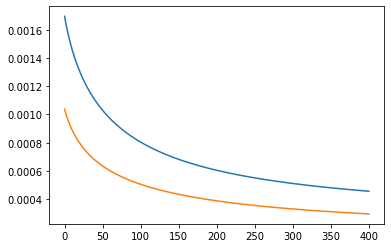

In [11]:
plt.plot(E_103818_m)
plt.plot(E_111312_m)

In [12]:
print(E_103818_m[0]/E_111312_m[0])

1.6322318211562814


In [13]:
# mask = mask0+mask2
# sio.savemat('InvThreshBrainTemplateEbin1k/mask_reg_0.mat', {'mask': mask.detach().numpy()})

### Save template

In [14]:
# sio.savemat('InvThreshBrainTemplateEbin3k/E_103818_m_ebin.mat', {'energy': E_103818_m})
# sio.savemat('InvThreshBrainTemplateEbin3k/E_111312_m_ebin.mat', {'energy': E_111312_m})

In [15]:
# plot_diffeo(phi_inv2_final, step_size=2, show_axis=True)
# plot_diffeo(phi_inv0_final, step_size=2, show_axis=True)
# plot_diffeo(phi2_final, step_size=2, show_axis=True)
# plot_diffeo(phi0_final, step_size=2, show_axis=True)

In [16]:
gmm = np.zeros((height,width,3))
gmm[:,:,0]=gm[:,:,0,0]
gmm[:,:,1]=gm[:,:,0,1]
gmm[:,:,2]=gm[:,:,1,1]
sitk.WriteImage(GetSITKImageFromNP(gmm, has_component_data=True), 'brain103818_111312_noweight_thresh_tensors.nhdr')
# sio.savemat('InvThreshBrainTemplateEbin1k/111312toTemp_noweight_phi_inv_ebin.mat', {'diffeo': phi_inv2_final.detach().numpy()})
# sio.savemat('InvThreshBrainTemplateEbin1k/111312toTemp_noweight_phi_ebin.mat', {'diffeo': phi2_final.detach().numpy()})
# sio.savemat('InvThreshBrainTemplateEbin1k/103818toTemp_noweight_phi_inv_ebin.mat', {'diffeo': phi_inv0_final.detach().numpy()})
# sio.savemat('InvThreshBrainTemplateEbin1k/103818toTemp_noweight_phi_ebin.mat', {'diffeo': phi0_final.detach().numpy()})

In [17]:
# def plot_diffeo_custom(diffeo, title, step_size=1, show_axis=False):
#     diffeo = diffeo.detach().numpy()
#     import matplotlib.pyplot as plt
#     #
#     plt.figure(num=None,figsize=(7.25,8.7),  dpi=100, facecolor='w', edgecolor='k')
#     plt.tight_layout(pad=0)
#     if show_axis is False:
#         plt.axis('off')
#     ax = plt.gca()
#     ax.set_aspect('equal')
#     for h in range(0, diffeo.shape[1], step_size):
#         plt.plot(diffeo[1, h, :], diffeo[0, h, :], 'k', linewidth=0.5)
# #         plt.plot(diffeo[0, h, :], diffeo[1, h, :], 'k', linewidth=0.5)
#     for w in range(0, diffeo.shape[2], step_size):
#         plt.plot(diffeo[1, :, w], diffeo[0, :, w], 'k', linewidth=0.5)
# #         plt.plot(diffeo[0, :, w], diffeo[1, :, w], 'k', linewidth=0.5)
        
# #     if(title):
# #         plt.title(title)
#     plt.savefig(title, bbox_inches='tight')
#     plt.show()

In [18]:
# plot_diffeo_custom(phi0_final, '103818toTemp', step_size=2)
# plot_diffeo_custom(phi2_final, '111312toTemp', step_size=2)

In [19]:
# path = 'InvThreshBrainTemplateEbin5k/111312toTemp_noweight_2000_phi_inv_ebin'
# plot_diffeo_custom(torch.from_numpy(sio.loadmat(path+'.mat')['diffeo']).double(), path+'.pdf', step_size=2)

In [20]:
# np.min((np.sqrt(-1),3.14))

In [21]:
# plot_diffeo_custom(phi0_final, '103818', step_size=3)
# plot_diffeo_custom(phi2_final, '111312', step_size=3)

In [22]:
# idty = compose_function(torch.from_numpy(sio.loadmat('InvThreshBrainTemplateEbin5k/111312toTemp_noweight_4000_phi_ebin.mat')['diffeo']).double(), torch.from_numpy(sio.loadmat('InvThreshBrainTemplateEbin5k/111312toTemp_noweight_4000_phi_inv_ebin.mat')['diffeo']).double())
# plot_diffeo(idty, step_size=2, show_axis=True)